## visualize demographical and IQ distributions of both groups
in order to balance them --> adjust recruitments strategies of remaining subjects

* plot of mean_iq (and its subscales: ME, KN), age, gender for groups seperately + 2sampleTTest (which should be not significant, but is....)
* plot over  subjects (effects of me as experminter, pratice effects etc. ) [here I detected that I forgot to add the 9/4 points to kn/me as the skipped levels]
* age per group per gender


** sorry, the way the tables are organized is a bit messy, the script tries to respect that
--> next time have a concepr ready at the beginning and be consistent when using multiple documents for the different batches of participants!

In [2]:
import pandas as pd
import numpy as np
import os.path as op

In [4]:
# Data from participants (ag & gender)

#df_participants = pd.read_csv('/Users/mrenke/data/ds-dnumrisk/add_tables/subjects_recruit&scan_scanned_march24.csv', header=1) #, index_col=0
df_participants = pd.read_csv('/Users/mrenke/data/ds-dnumrisk/add_tables/subjects_recruit&scan_scanned-final.csv', header=0) #, index_col=0

df_participants = df_participants.loc[:,['subject ID', 'age','group','gender']].rename(mapper={'subject ID': 'subject'},axis=1).dropna().astype({'subject': int, 'group': int}).set_index('subject')
df_participants.head()

,age,group,gender
subject,,,
1,19,0,w
2,17,1,w
3,15,0,w
4,17,1,w
5,20,0,w


In [5]:
# Normen für IDS-2
file_IDS2_screen_norms = '/Users/mrenke/Desktop/DNumRisk/addiMeasures/IDS-2_screener_normen.xlsx'
norms_mat = pd.read_excel(file_IDS2_screen_norms, 'ME') # matrix reasoning
norms_cat = pd.read_excel(file_IDS2_screen_norms, 'KN') # category naming

norms_mat.columns = [x for x in range(0, len(norms_mat.columns))] 
norms_mat.loc[0,0:5] = np.arange(15,21)
norms_mat = norms_mat.rename(mapper={6:'IQ'},axis=1)

norms_cat.columns = [x for x in range(0, len(norms_cat.columns))] 
norms_cat.loc[0,0:5] = np.arange(15,21)
norms_cat = norms_cat.rename(mapper={6:'IQ'},axis=1)
norms_cat = norms_cat.loc[:14,:]

In [7]:
# IDS-Screener results from participants (multiple files!)
bids_folder = '/Users/mrenke/data/ds-dnumrisk'
am1_cat = pd.read_excel(op.join(bids_folder,'add_tables','add_measure_1.xlsx'), sheet_name='IDS - Kategorien')
am1_matrices = pd.read_excel(op.join(bids_folder,'add_tables','add_measure_1.xlsx'), sheet_name='IDS- Matrizen')

am2_cat = pd.read_excel(op.join(bids_folder,'add_tables','add_measure_2.xlsx'), sheet_name='Kategorien_nennen')
am2_matrices = pd.read_excel(op.join(bids_folder,'add_tables','add_measure_2.xlsx'), sheet_name='Matrizen_ergänzen')

am3_cat = pd.read_excel(op.join(bids_folder,'add_tables','add_measure_3.xlsx'), sheet_name='kategorien_nennen')
am3_matrices = pd.read_excel(op.join(bids_folder,'add_tables','add_measure_3.xlsx'), sheet_name='matrizen_ergänzen')



In [8]:
# 1.: select row with sub ID and mean score, 2.: transpose, 3.: drop NaNs and other row, 4.: rename columns, 5.: set index to subject ID
df_am1_cat =am1_cat.loc[[6,35],:].T.dropna(axis=0).rename(mapper={6:'subject',35:'cat_score'},axis=1).astype({'subject': int}).set_index('subject')
df_am1_matrices = am1_matrices.loc[[1,37], :].T.dropna(axis=0).rename(mapper={1:'subject',37:'mat_score'},axis=1).astype({'subject': int}).set_index('subject')
df_am2_cat = am2_cat.loc[[2,29],:].T.dropna(axis=0).drop('Unnamed: 2').rename(mapper={2:'subject',29:'cat_score'},axis=1).astype({'subject': int}).set_index('subject')
df_am2_matrices = am2_matrices.loc[[2,36], :].T.dropna(axis=0).rename(mapper={2:'subject',36:'mat_score'},axis=1).astype({'subject': int}).set_index('subject')
df_am3_cat =am3_cat.loc[[2,29],:].T.dropna(axis=0).drop('Unnamed: 2').rename(mapper={2:'subject',29:'cat_score'},axis=1).astype({'subject': int}).set_index('subject')
df_am3_matrices =am3_matrices.loc[[2,36],:].T.dropna(axis=0).drop('Unnamed: 2').rename(mapper={2:'subject',36:'mat_score'},axis=1).astype({'subject': int}).set_index('subject')

# add the points of the levels that are skipped for that age group (for add_measure_1 this is already done in the table)
df_am2_cat += 9
df_am2_matrices += 4
df_am3_cat += 9
df_am3_matrices += 4

# join everyhting
df_scores= pd.concat([df_am1_cat,df_am2_cat, df_am3_cat]).join(pd.concat([df_am1_matrices,df_am2_matrices, df_am3_matrices]))
df_scores.sort_index(inplace=True)
df_scores.head()

,cat_score,mat_score
subject,,
1,29,25
2,26,18
3,23,23
4,28,22
5,31,15.0


In [9]:
# get IQ scores for each subject

subject_list= df_participants.reset_index()['subject'].unique()

iqs = []
for sub in subject_list:
    age = df_participants.loc[sub,'age']
    if age > 20:
        age = 20
    score_KN = df_scores.loc[sub,'cat_score']
    score_ME = df_scores.loc[sub,'mat_score']

    col = np.where(norms_mat.loc[0,:] == age)[0][0]
    row = np.where(norms_mat.loc[:,col] <= score_ME)[0].max()
    iq_ME = norms_mat.loc[row,'IQ']

    col = np.where(norms_cat.loc[0,:] == age)[0][0]
    row = np.where(norms_cat.loc[:,col] <= score_KN)[0].max()
    iq_KN = norms_cat.loc[row,'IQ']

    iqs.append([iq_ME, iq_KN])


In [10]:
df_comb = pd.concat([pd.DataFrame(iqs,columns=['me','kn']), df_participants.reset_index()], axis=1).set_index('subject')
df_comb['mean_iq'] = df_comb[['me','kn']].mean(axis=1)
df_comb.head()

,me,kn,age,group,gender,mean_iq
subject,,,,,,
1,120.0,105.0,19,0,w,112.5
2,100.0,95.0,17,1,w,97.5
3,115.0,95.0,15,0,w,105.0
4,110.0,105.0,17,1,w,107.5
5,90.0,115.0,20,0,w,102.5


In [138]:
# look at single subjects
df_comb.loc[54] #  54 - liv (0, 17), 46 - neva (1, 23)

me         65.0
kn         85.0
age        16.0
group         0
gender        w
mean_iq    75.0
Name: 54, dtype: object

/Users/mrenke/mambaforge/envs/behav_fit/lib/python3.10/site-packages/pingouin/parametric.py:261: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  tval, pval = ttest_ind(x, y, equal_var=False, alternative=alternative)
/Users/mrenke/mambaforge/envs/behav_fit/lib/python3.10/site-packages/pingouin/effsize.py:804: RuntimeWarning: divide by zero encountered in double_scalars
  d = (x.mean() - y.mean()) / poolsd
/Users/mrenke/mambaforge/envs/behav_fit/lib/python3.10/site-packages/pingouin/parametric.py:280: RuntimeWarning: invalid value encountered in multiply
  ci = np.array([tval - tcrit, tval + tcrit]) * se
/Users/mrenke/mambaforge/envs/behav_fit/lib/python3.10/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warni

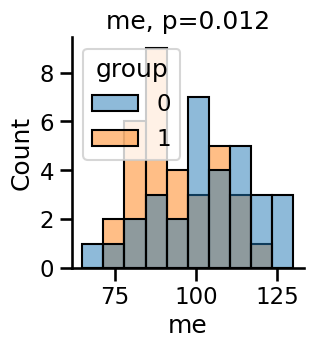

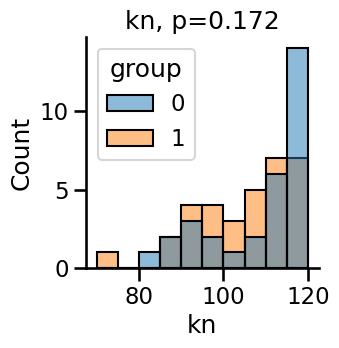

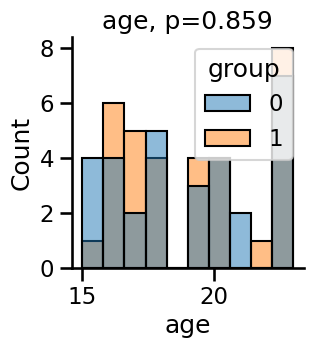

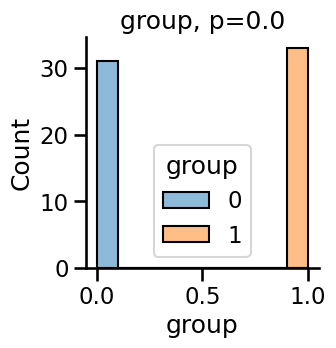

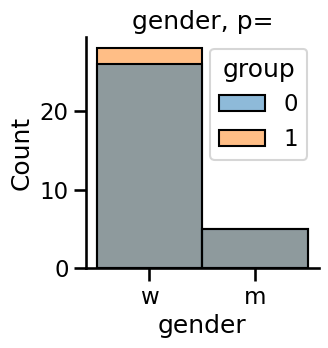

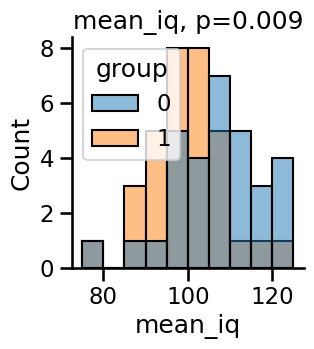

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg
sns.set_context('talk')

var = 'age'#'kn'#'mean_iq''gender'# ['age','kn','me','mean_iq']
for var in df_comb.columns:
    plt.figure(figsize=(3,3))
    sns.histplot(data=df_comb, x=var,hue='group',bins=10)

    g0 = df_comb.loc[df_comb['group']==0][var]
    g1 = df_comb.loc[df_comb['group']==1][var]

    try: 
        pval = np.round(pg.ttest(g0,g1)['p-val'].values[0], 3)
    except:
        pval = ''
    plt.title(f'{var}, p={pval}')
    sns.despine()

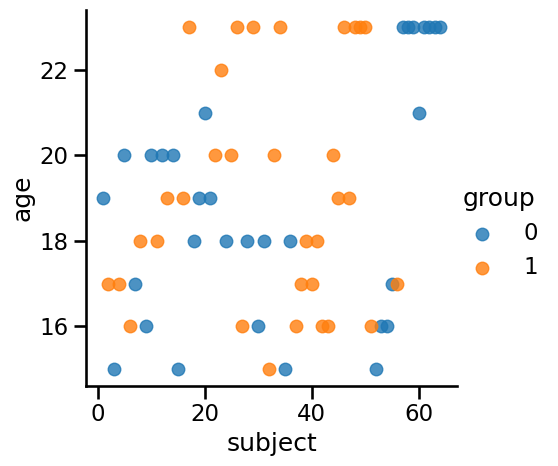

In [12]:
# plot over  subjects (effects of me as experminter, pratice effects etc. )
# but also just had 'dummer' subjects more recently than at the beginning....
sns.lmplot(data=df_comb.reset_index(), x='subject',y='age',hue='group',fit_reg=False)

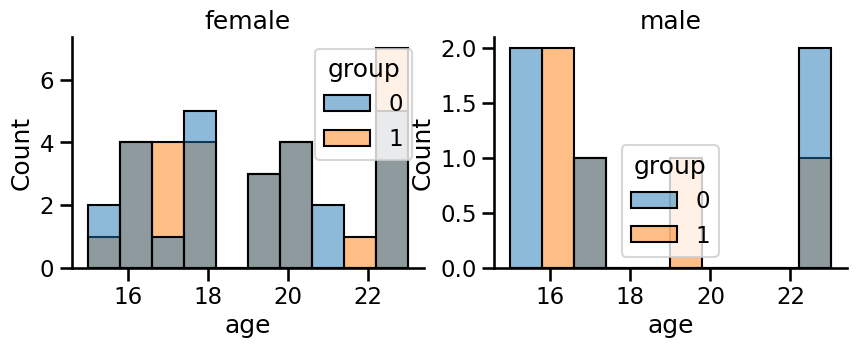

In [13]:
# age per group per gender

fig, axes = plt.subplots(1,2, figsize=(10,3))
sns.histplot(data=df_comb[df_comb['gender']=='w'], x='age',hue='group', bins=10, ax=axes[0]).set_title('female')
sns.histplot(data=df_comb[df_comb['gender']=='m'], x='age',hue='group',bins=10, ax=axes[1]).set_title('male')
sns.despine()


In [154]:
df_comb[df_comb['age']==23]

,me,kn,age,group,gender,mean_iq
subject,,,,,,
17,90.0,120.0,23.0,1,w,105.0
26,95.0,110.0,23.0,1,w,102.5
29,110.0,120.0,23.0,1,w,115.0
34,80.0,95.0,23.0,1,w,87.5
46,80.0,70.0,23.0,1,w,75.0
48,115.0,85.0,23.0,1,w,100.0
49,115.0,100.0,23.0,1,m,107.5
50,85.0,115.0,23.0,1,w,100.0


In [ ]:
# find old script that I remember to have written, but can't find anymore

import os
import nbformat

# Paths that I remember should be inlcuded in the scripts
paths_to_find = [
    '/Users/mrenke/data/ds-dnumrisk/add_tables/subjects_recruit&scan.xlsx',
    '/Users/mrenke/Desktop/DNumRisk/addiMeasures/IDS-2_screener_normen.xlsx'
]

# Start from the root directory
root_dir = '/'

for dir_name, sub_dir_list, file_list in os.walk(root_dir):
    for file_name in file_list:
        if file_name.endswith('.ipynb'):
            file_path = os.path.join(dir_name, file_name)
            with open(file_path, 'r') as f:
                try:
                    nb = nbformat.read(f, as_version=4)
                    for cell in nb.cells:
                        if cell.cell_type == 'code':
                            for path in paths_to_find:
                                if path in cell.source:
                                    print(f'Found in {file_path}')
                except Exception as e:
                    print(f'Error reading file {file_path}: {e}')

# indeed found old script with this, 
# apparently it was (autimatically) saved by VSCode, not by me, in the following location:
# "/System/Volumes/Data/Users/mrenke/Library/Application Support/Code/User/History/13d2a088"